# Data Loading

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Pre Processing

## Importing Necessary Libraries

In [ ]:
import os
from PIL import Image
import cv2
from tqdm import tqdm

## Reshaping Image Dimension (64 x 64)

In [ ]:
# source & destination folders
src_base = '/content/drive/MyDrive/animals'
dst_base = '/content/drive/MyDrive/pre_processed_animals'
img_size = 64

# Animal categories
categories = ['cats', 'dogs', 'panda']

# Create destination directories if it doesn't exist
for category in categories:
    os.makedirs(os.path.join(dst_base, category), exist_ok=True)

for category in categories:
    src_folder = os.path.join(src_base, category)
    dst_folder = os.path.join(dst_base, category)

    for img_name in tqdm(os.listdir(src_folder), desc=f"Processing {category}"):
        src_path = os.path.join(src_folder, img_name)
        dst_path = os.path.join(dst_folder, img_name)

        # Skip if image already exist
        if os.path.exists(dst_path):
            continue

        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert back for OpenCV save

            # Save the resized image
            cv2.imwrite(dst_path, img)

        except Exception as e:
            print(f"Error processing {img_name}: {e}")


Processing panda: 100%|██████████| 130/130 [00:02<00:00, 49.25it/s]


Loading panda: 100%|██████████| 100/100 [00:00<00:00, 151.71it/s]


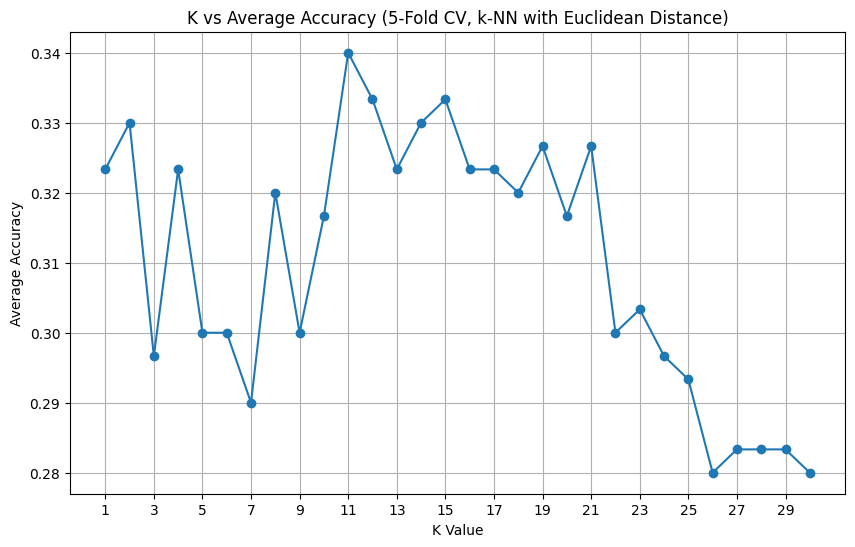

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION --- #
base_dir = '/content/drive/MyDrive/processed_animals'
categories = ['cats', 'dogs', 'panda']
img_size = 64
num_folds = 5
max_k = 30

# --- LOAD AND PREPROCESS IMAGES --- #
data = []
labels = []

for label_index, category in enumerate(categories):
    path = os.path.join(base_dir, category)
    for img_name in tqdm(os.listdir(path), desc=f"Loading {category}"):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            data.append(img.flatten())
            labels.append(label_index)
        except Exception as e:
            continue

X = np.array(data)
y = np.array(labels)

# --- SHUFFLE AND SPLIT INTO FOLDS --- #
np.random.seed(42)
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]
folds_X = np.array_split(X, num_folds)
folds_y = np.array_split(y, num_folds)
folds = list(zip(folds_X, folds_y))

# --- k-NN CLASSIFICATION --- #
def knn_predict(test_sample, X_train, y_train, k):
    distances = np.linalg.norm(X_train - test_sample, axis=1)
    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_indices]
    return np.bincount(nearest_labels).argmax()

average_accuracies = []

for k in range(1, max_k + 1):
    fold_accuracies = []

    for i in range(num_folds):
        X_test, y_test = folds[i]
        X_train = np.vstack([folds[j][0] for j in range(num_folds) if j != i])
        y_train = np.hstack([folds[j][1] for j in range(num_folds) if j != i])

        predictions = [knn_predict(sample, X_train, y_train, k) for sample in X_test]
        acc = np.mean(np.array(predictions) == y_test)
        fold_accuracies.append(acc)

    avg_acc = np.mean(fold_accuracies)
    average_accuracies.append(avg_acc)

# --- PLOT THE RESULTS --- #
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), average_accuracies, marker='o', linestyle='-')
plt.title('K vs Average Accuracy (5-Fold CV, k-NN with Euclidean Distance)')
plt.xlabel('K Value')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(range(1, max_k + 1, 2))
plt.show()
